In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_dir = 'D:/ITU/Spring 2020/Deep Learning/Assignments/Assignment 05/Assignment 5 Dataset/Assignment 5 Dataset'

In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


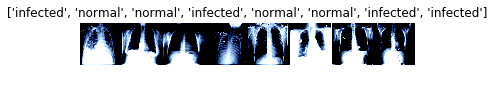

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [5]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# Freeze training for all layers
for param in vgg16.parameters():
    param.require_grad = False
num_features = vgg16.classifier[0].in_features  # 25088
features = [] # Remove last layer
last_two_digits = 4
neurons = (10 * last_two_digits) + 100  # 140
features.extend([nn.Linear(num_features, neurons)])
features.extend([nn.Linear(neurons, len(class_names))])
# print(features)
vgg16.classifier = nn.Sequential(*features)
print(vgg16.classifier)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Sequential(
  (0): Linear(in_features=25088, out_features=140, bias=True)
  (1): Linear(in_features=140, out_features=2, bias=True)
)


In [6]:
# Load ResNet
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)
for param in resnet18.parameters():
    param.requires_grad = False
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000 
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, len(class_names))
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000 
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

Output Layer of resnet18 :  1000
Output Layer of resnet18 :  2


In [7]:
Epochs = 3
criterion = nn.CrossEntropyLoss()


In [8]:
model = vgg16
# OR
# model = resnet18

In [ ]:
from tqdm import tqdm

model.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # Using 3rd of data
        if i % 5 != 0:
            continue
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(model.state_dict(), 'vgg16_FC_only.pth')
#     torch.save(model.state_dict(), 'resnet18_FC_only.pth')

print('Finished Training')

Train Epoch: 0 [1000/2684 (37%)]	Loss: 0.929576: : 126it [06:10,  2.80s/it]

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [ ]:
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [ ]:
correct = 0
total = 0
testY = []
predictions = []
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        testY += list(labels.numpy())
        predictions += list(predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#         if total > 1000:
#             break

accuracy = 100 * correct / total
print(f'Accuracy of the network on {total} test images: {accuracy}')

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, f1_score
confusion_matrix(testY, predictions)

In [ ]:
f1_score(testY, predictions)